# Install dependencies

In [1]:
!pip install --quiet tensorflow keras matplotlib seaborn scikit-learn pydot graphviz gradio PyPDF2 pdf2image pytesseract
!apt-get install -y poppler-utils > /dev/null


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 7.7 MB/s eta 0:00:00


# IMPORT LIBRARIES

In [2]:
import os
import tempfile
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from keras import layers

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from IPython.display import Image, display

from PyPDF2 import PdfReader
from pdf2image import convert_from_path
import pytesseract


# --- (3) CONFIGURATION / HYPERPARAMETERS ---

In [3]:
max_features = 20000
max_len = 200
embedding_dim = 128
lstm_units = 64
batch_size = 32
epochs = 5

# --- (4) BUILD BIDIRECTIONAL LSTM MODEL (Functional API) ---

In [4]:
inp = keras.Input(shape=(None,), dtype="int32", name="input_tokens")
x = layers.Embedding(input_dim=max_features, output_dim=embedding_dim, name="embedding")(inp)

x = layers.Bidirectional(layers.LSTM(lstm_units, return_sequences=True), name="bilstm_1")(x)
x = layers.Dropout(0.5, name="dropout_1")(x)

x = layers.Bidirectional(layers.LSTM(lstm_units), name="bilstm_2")(x)
x = layers.Dropout(0.5, name="dropout_2")(x)

x = layers.Dense(64, activation="relu", name="dense_1")(x)
out = layers.Dense(1, activation="sigmoid", name="output")(x)

model = keras.Model(inputs=inp, outputs=out, name="bidirectional_imdb_model")
model.summary()


Model: "bidirectional_imdb_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_tokens (InputLayer)       │ (None, None)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, None, 128)      │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bilstm_1 (Bidirectional)        │ (None, None, 128)      │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, None, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bilstm_2 (Bidirectional)        │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,765,953 (10.55 MB)

 Trainable params: 2,765,953 (10.55 MB)

 Non-trainable params: 0 (0.00 B)

# --- (5) LOAD & PREPROCESS IMDB DATA ---

In [5]:
(X_train, y_train), (X_val, y_val) = keras.datasets.imdb.load_data(num_words=max_features)

print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")

X_train = keras.preprocessing.sequence.pad_sequences(X_train, maxlen=max_len)
X_val   = keras.preprocessing.sequence.pad_sequences(X_val,   maxlen=max_len)


17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Training samples: 25000
Validation samples: 25000


# --- (6) COMPILE & TRAIN MODEL ---

In [6]:
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

history = model.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val)
)


Epoch 1/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 40s 42ms/step - accuracy: 0.7326 - loss: 0.5079 - val_accuracy: 0.8399 - val_loss: 0.3688
Epoch 2/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 33s 42ms/step - accuracy: 0.9166 - loss: 0.2239 - val_accuracy: 0.8631 - val_loss: 0.3559
Epoch 3/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 34s 43ms/step - accuracy: 0.9595 - loss: 0.1186 - val_accuracy: 0.8635 - val_loss: 0.4069
Epoch 4/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 33s 42ms/step - accuracy: 0.9689 - loss: 0.0930 - val_accuracy: 0.8620 - val_loss: 0.4611
Epoch 5/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 33s 42ms/step - accuracy: 0.9746 - loss: 0.0720 - val_accuracy: 0.8527 - val_loss: 0.5041


# --- (7) PLOT TRAINING & VALIDATION LOSS / ACCURACY ---

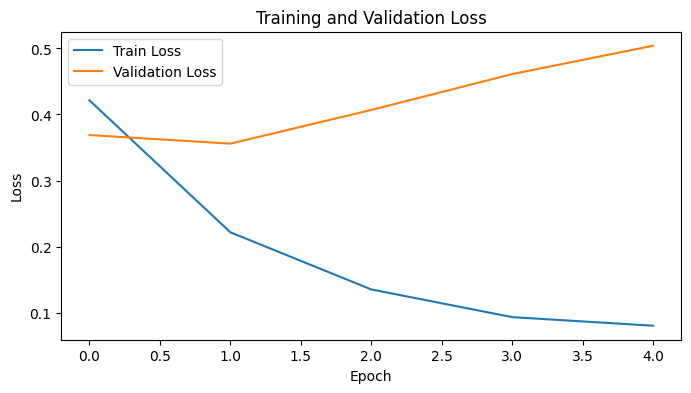

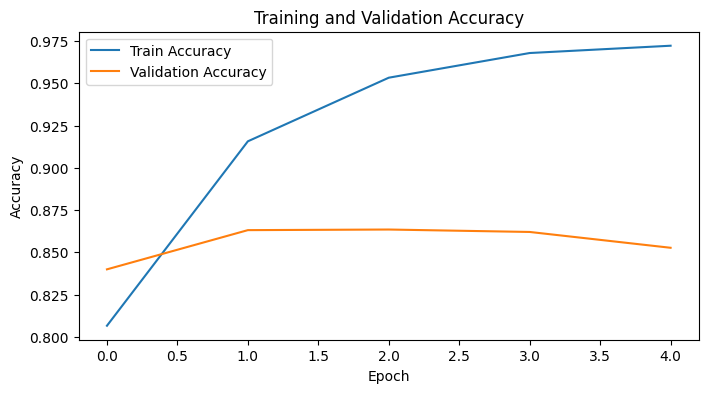

In [7]:
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.show()

plt.figure(figsize=(8, 4))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(); plt.show()


# SAVE & DISPLAY MODEL DIAGRAM

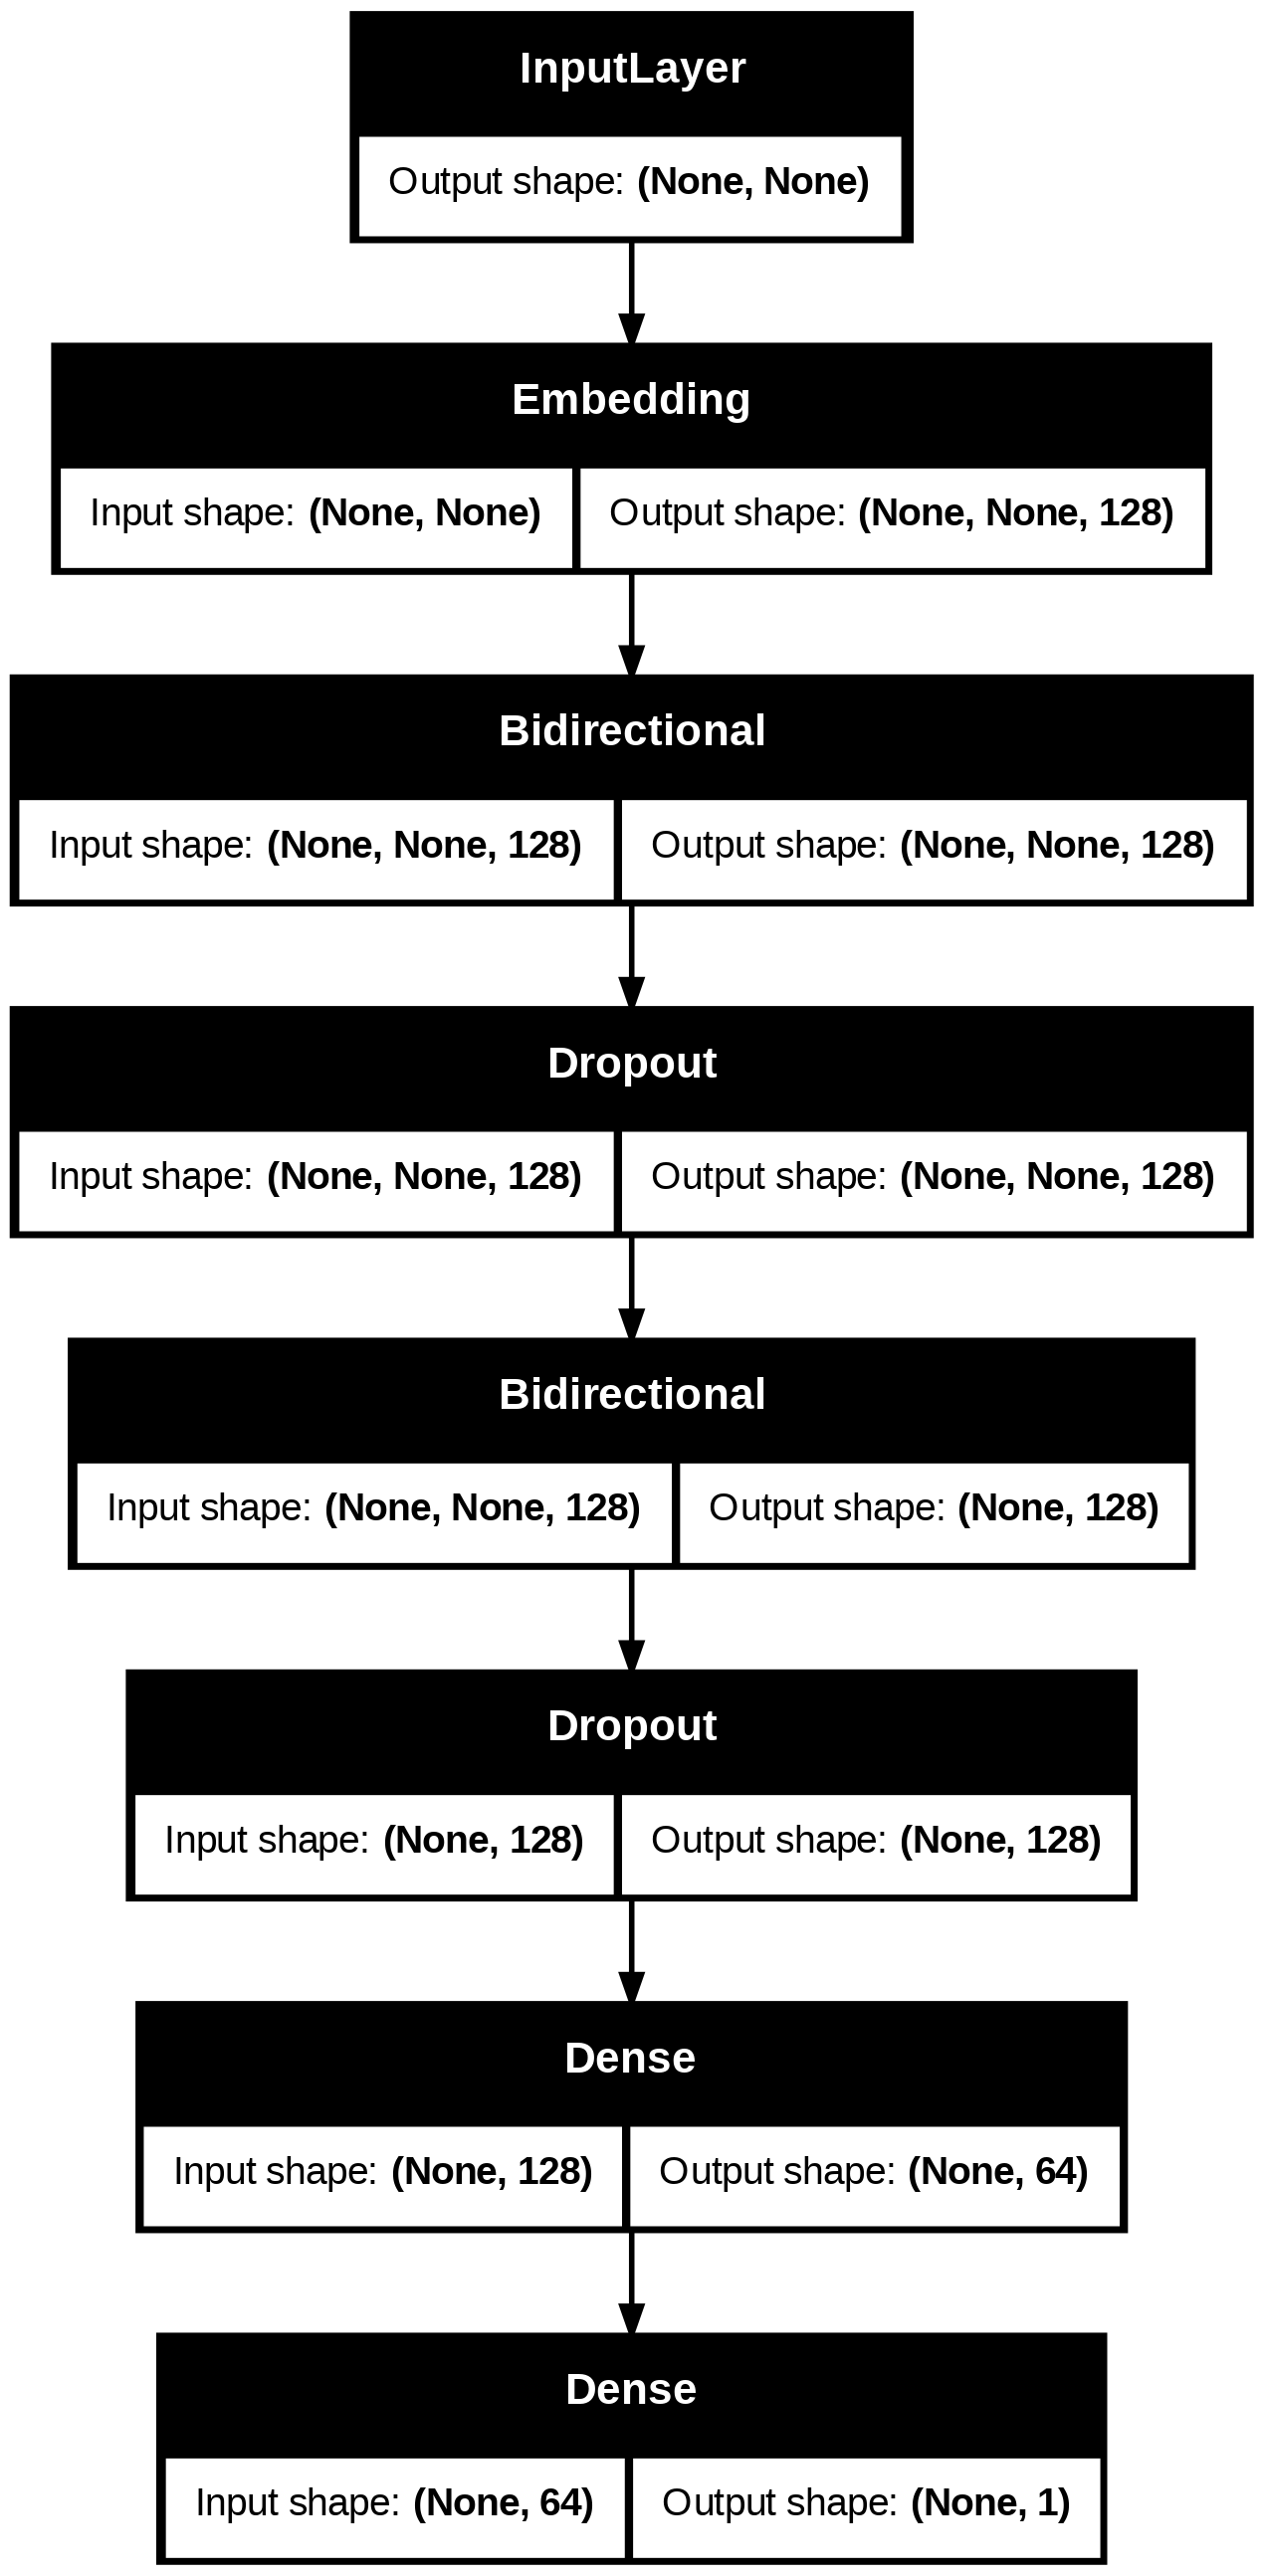

In [8]:
try:
    from keras.utils import plot_model
    plot_model(model, show_shapes=True, to_file='model_architecture.png')
    display(Image('model_architecture.png'))
except Exception as e:
    print("Could not produce model diagram. Ensure 'pydot' and system graphviz are installed.")
    print("Error:", e)


# --- (9) CONFUSION MATRIX ON VALIDATION SET ---

391/391 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step


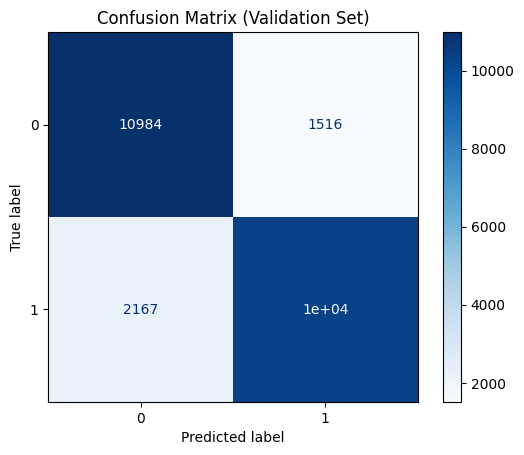

In [9]:
y_pred_probs = model.predict(X_val, batch_size=64)
y_pred = (y_pred_probs.flatten() >= 0.5).astype(int)

cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix (Validation Set)")
plt.show()


# SAVE MODEL

In [10]:
model.save("bidirectional_imdb_model.h5")
print("✅ Model saved to bidirectional_imdb_model.h5")


✅ Model saved to bidirectional_imdb_model.h5


# --- (11) SETUP WORD INDEX FOR ENCODING RAW TEXT REVIEWS ---

In [11]:
from tensorflow.keras.datasets import imdb

word_index = imdb.get_word_index()
index_from = 3
word_index = {k: (v + index_from) for k, v in word_index.items()}

word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2
word_index["<UNUSED>"] = 3

reverse_word_index = {value: key for (key, value) in word_index.items()}


1641221/1641221 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


# --- (12) ENCODE RAW TEXT & PREDICTION HELPERS ---

In [12]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import text_to_word_sequence

def encode_review(text, maxlen=max_len):
    tokens = text_to_word_sequence(text)
    encoded = [1]  # <START>
    for word in tokens:
        encoded.append(word_index.get(word, 2))
    return pad_sequences([encoded], maxlen=maxlen)

def predict_sentiment_from_text(text):
    seq = encode_review(text)
    prob = float(model.predict(seq)[0][0])
    sentiment = "🌟 Positive" if prob >= 0.5 else "💔 Negative"
    confidence = prob if prob >= 0.5 else 1 - prob
    return sentiment, prob, confidence


# --- (13) QUICK MANUAL TESTS ---

In [13]:
tests = [
    "This movie was fantastic! I loved the acting and the plot.",
    "Terrible movie. Waste of time and money. The plot was boring."
]

for t in tests:
    sentiment, prob, conf = predict_sentiment_from_text(t)
    print(f"Text: {t}\nPrediction: {sentiment}  (prob={prob:.3f}, confidence={conf:.3f})\n")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
Text: This movie was fantastic! I loved the acting and the plot.
Prediction: 🌟 Positive  (prob=0.981, confidence=0.981)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
Text: Terrible movie. Waste of time and money. The plot was boring.
Prediction: 💔 Negative  (prob=0.001, confidence=0.999)



# --- (14) ADVANCED GRADIO UI WITH CONFIDENCE BAR, FILE UPLOAD & THRESHOLD CONTROL ---

In [17]:
# --- (14) ADVANCED GRADIO UI: TXT, PDF (text) & SCANNED PDF (OCR) SUPPORT ---
import gradio as gr

# Single review analysis (same logic)
def analyze_single_review(review_text, threshold=0.5):
    if not isinstance(review_text, str) or not review_text.strip():
        return "⚠️ Please enter a review.", 0.0
    seq = encode_review(review_text)
    prob = float(model.predict(seq)[0][0])
    sentiment = "🌟 Positive" if prob >= threshold else "💔 Negative"
    confidence = prob if prob >= threshold else 1 - prob
    label = f"{sentiment}  (probability: {prob:.3f})"
    return label, confidence

# Batch analysis (same logic)
def analyze_file(file, threshold=0.5):
    if file is None:
        return pd.DataFrame([], columns=["Review", "Probability", "Sentiment"])
    filename = file.name.lower()
    text_data = ""
    try:
        if filename.endswith(".pdf"):
            reader = PdfReader(file)
            pdf_text = ""
            for page in reader.pages:
                ptext = page.extract_text()
                if ptext:
                    pdf_text += ptext + "\n"
            if not pdf_text.strip():
                with tempfile.TemporaryDirectory() as path:
                    temp_pdf = os.path.join(path, "temp.pdf")
                    with open(temp_pdf, "wb") as f:
                        f.write(file.read())
                    images = convert_from_path(temp_pdf)
                    text_chunks = [pytesseract.image_to_string(img) for img in images]
                    pdf_text = "\n".join(text_chunks)
            text_data = pdf_text
        else:
            raw = file.read()
            text_data = raw.decode("utf-8", errors="ignore")
    except Exception as e:
        return pd.DataFrame([{"Review": f"Error reading file: {e}", "Probability": None, "Sentiment": "Error"}])

    lines = [ln.strip() for ln in text_data.splitlines() if ln.strip()]
    results = []
    for review in lines:
        seq = encode_review(review)
        prob = float(model.predict(seq)[0][0])
        sentiment = "Positive" if prob >= threshold else "Negative"
        results.append({
            "Review": review if len(review) <= 200 else review[:197] + "...",
            "Probability": round(prob, 3),
            "Sentiment": sentiment
        })
    if not results:
        return pd.DataFrame([], columns=["Review", "Probability", "Sentiment"])
    return pd.DataFrame(results)

# Build Unique Gradio UI
with gr.Blocks(title="🎬 IMDB Sentiment Analyzer") as demo:
    # Header Section
    gr.HTML("""
    <div style="
        background: linear-gradient(135deg, #2c5364, #203a43, #0f2027);
        color: white;
        padding: 25px;
        border-radius: 12px;
        text-align: center;
        margin-bottom: 25px;
        box-shadow: 0 4px 20px rgba(0,0,0,0.4);
    ">
        <h1 style="margin-bottom:8px; font-size:30px;">🎬 IMDB Sentiment Analyzer (Enhanced + OCR)</h1>
        <p style="font-size:15px; color:#ddd;">
        Upload a <b>.txt</b> or <b>.pdf</b> file (supports text & scanned PDFs) — or analyze one review instantly.
        </p>
    </div>
    """)

    with gr.Tab("🗣️ Single Review"):
        with gr.Row():
            with gr.Column(scale=6):
                review_input = gr.Textbox(lines=6, placeholder="✍️ Type your movie review here...", label="Enter Review")
                threshold_slider = gr.Slider(0.1, 0.9, value=0.5, label="🎚️ Positive Sentiment Threshold")
                analyze_button = gr.Button("🔍 Analyze Sentiment", variant="primary", elem_id="analyze-btn")
            with gr.Column(scale=4):
                output_label = gr.Textbox(label="🎯 Predicted Sentiment & Probability")
                confidence_bar = gr.Slider(0, 1, value=0, label="📈 Confidence", interactive=False)

        analyze_button.click(analyze_single_review,
                             inputs=[review_input, threshold_slider],
                             outputs=[output_label, confidence_bar])

    with gr.Tab("📂 File Upload (Batch Mode)"):
        gr.Markdown("### 📑 Upload your dataset for batch analysis")
        with gr.Row():
            file_input = gr.File(label="Upload a text (.txt) or PDF (.pdf) file")
            threshold_batch = gr.Slider(0.1, 0.9, value=0.5, label="Positive Sentiment Threshold (Batch)")
        analyze_file_button = gr.Button("📊 Analyze Uploaded File", variant="secondary")
        file_output = gr.DataFrame(headers=["Review", "Probability", "Sentiment"], label="Results")
        analyze_file_button.click(analyze_file,
                                  inputs=[file_input, threshold_batch],
                                  outputs=file_output)

    # Footer Section
    gr.HTML("""
    <div style="
        margin-top:35px;
        background: #0f2027;
        background: linear-gradient(90deg, #203a43, #2c5364);
        color: #eee;
        padding: 18px;
        border-radius: 10px;
        text-align: center;
        box-shadow: 0 2px 15px rgba(0,0,0,0.3);
    ">
        <h3 style="margin:4px 0;">🧑‍💻 Developed by <span style="color:#4fc3f7;">Md. Ferdaus Hossen</span></h3>
        <h5 style="margin:2px 0;">Junior AI/ML Engineer at <span style="color:#80cbc4;">Zensoft Lab</span></h5>
        <div style="margin-top:8px;">
            <a href="https://github.com/Ferdaus71" target="_blank" style="margin-right:12px;">
                <img src="https://cdn.jsdelivr.net/gh/simple-icons/simple-icons/icons/github.svg" width="24" alt="GitHub" style="filter:invert(1)">
            </a>
            <a href="https://www.linkedin.com/in/ferdaus70/" target="_blank">
                <img src="https://cdn.jsdelivr.net/gh/simple-icons/simple-icons/icons/linkedin.svg" width="24" alt="LinkedIn" style="filter:invert(1)">
            </a>
        </div>
        <p style="font-size:12px;color:#ccc;margin-top:8px;">© 2025 All rights reserved</p>
    </div>
    """)

# Launch app
demo.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://cf6d994b4adad8f19c.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
